# Libraries

In [ ]:
!pip install imbalanced-learn

In [ ]:
!pip install lime

In [ ]:
!pip install shap

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.tree import _tree, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
from sklearn.tree import _tree
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import shap
import lime
import lime.lime_tabular

# Load & Split Dataset

In [ ]:
df = pd.read_csv("/content/df_cleaned.csv")
df

,last_pymnt_d,total_rec_prncp,last_pymnt_amnt,out_prncp,total_rec_late_fee,last_fico_range_high,installment,loan_amnt,total_rec_int,out_prncp_inv,...,funded_amnt_inv,recoveries,debt_settlement_flag,hardship_flag,mo_sin_old_rev_tl_op,revol_util,dti,all_util,annual_inc,loan_status
0,17,-0.332581,-0.372797,0.420080,-0.261895,0.281611,-0.473027,-0.461473,0.413942,0.420298,...,-0.461004,-0.445598,0,0,-0.307356,0.608376,0.558953,0.915820,-1.203816,0
1,31,-0.840560,-0.473603,-0.629220,-0.261895,1.244049,-1.608631,-1.601510,-1.081823,-0.629167,...,-1.601271,-0.445598,0,0,-0.187187,-1.880835,-1.233491,-0.049124,0.274631,1
2,27,-0.250720,-0.222228,2.263937,-0.261895,0.883135,1.252073,1.058575,-0.380182,2.264445,...,1.059353,-0.445598,0,0,-0.980297,0.431193,-0.223328,0.379740,2.227297,1
3,39,-0.458023,0.161605,-0.629220,-0.261895,0.161306,-1.364264,-1.373503,-0.909433,-0.629167,...,-1.373218,-0.445598,0,0,-1.472987,0.314511,-0.337836,0.433348,-1.231711,1
4,5,-0.415519,0.220569,-0.629220,-0.261895,0.221459,-1.317547,-1.348168,-0.834440,-0.629167,...,-1.347878,-0.445598,0,0,0.738107,1.273894,0.117928,1.559116,-0.841178,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119281,36,1.072123,0.066746,-0.629220,-0.261895,0.822982,-0.473196,-0.461473,-0.593052,-0.629167,...,-0.461004,-0.445598,0,0,0.353569,0.720736,-0.931916,0.111700,4.179963,1
119282,26,0.475587,-0.417190,-0.629220,-0.261895,-1.462808,1.079697,0.555059,1.491599,-0.629167,...,0.555735,-0.445598,0,0,-0.727944,0.405263,-0.997673,2.309628,1.390440,0
119283,27,-0.983894,-0.414521,0.132695,-0.261895,1.003439,-0.951061,-1.078993,-0.949884,0.132868,...,-1.078649,-0.445598,0,0,2.336344,-0.109001,0.109992,-0.746028,-1.426978,1
119284,13,0.639197,-0.321768,-0.629220,3.433568,-0.981589,0.636417,1.311917,2.824325,-0.629167,...,1.312745,-0.445598,1,0,-0.259288,-0.484975,-0.158705,-0.049124,0.001258,0


In [ ]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

## Feature Selection

In [ ]:
# Scale features to [0,1] for Chi-Squared
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [ ]:
# Chi-Squared Feature Selection
selector = SelectKBest(score_func=chi2, k='all')
selector.fit(X_scaled, y)

SelectKBest(k='all', score_func=<function chi2 at 0x7b3804946de0>)

In [ ]:
# Select features with p-value < 0.01
p_values = selector.pvalues_
selected_features = X_scaled.columns[p_values < 0.01]
X_selected = X_scaled[selected_features]

print(f"Selected Features (p < 0.01): {list(selected_features)}")

Selected Features (p < 0.01): ['last_pymnt_d', 'total_rec_prncp', 'last_pymnt_amnt', 'out_prncp', 'total_rec_late_fee', 'last_fico_range_high', 'installment', 'loan_amnt', 'total_rec_int', 'out_prncp_inv', 'total_pymnt', 'funded_amnt_inv', 'recoveries', 'debt_settlement_flag', 'hardship_flag', 'mo_sin_old_rev_tl_op', 'revol_util', 'dti', 'all_util', 'annual_inc']


## Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

## Apply Random Oversampling to Training Data (skipped to make fair comparison)

In [ ]:
# # Oversample training data
# oversampler = RandomOverSampler(random_state=42)
# X_train_balanced, y_train_balanced = oversampler.fit_resample(X_train, y_train)

In [ ]:
# print(f"Original training set size: {X_train.shape}")
# print(f"Balanced training set size: {X_train_balanced.shape}")

# Random Forest Classifier

In [ ]:
def train_and_evaluate_random_forest(X_train, X_test, y_train, y_test, n_estimators=100, criterion='gini', random_state=42):
    """
    Train and evaluate a Random Forest model.

    Parameters:
    - X_train, X_test: Features for training and testing
    - y_train, y_test: Labels for training and testing
    - n_estimators (int): Number of trees (default 100)
    - criterion (str): Splitting criterion ('gini' or 'entropy', default 'gini')
    - random_state (int): Random seed (default 42)

    Returns:
    - rf_model: Trained Random Forest model
    """

    # Train Random Forest
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        criterion=criterion,
        random_state=random_state
    )
    rf_model.fit(X_train, y_train)

    # Predictions
    y_pred = rf_model.predict(X_test)
    y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

    # Evaluation Metrics
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob))

    # Confusion Matrix: [ [TN, FP], [FN, TP] ]
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    sensitivity = tp / (tp + fn)  # True Positive Rate
    specificity = tn / (tn + fp)  # True Negative Rate

    print(f"Sensitivity (True Positive Rate): {sensitivity:.4f}")
    print(f"Specificity (True Negative Rate): {specificity:.4f}")

    return rf_model


In [ ]:
rf_model = train_and_evaluate_random_forest(X_train, X_test, y_train, y_test, n_estimators=100)


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     17285
           1       0.99      0.99      0.99     18501

    accuracy                           0.99     35786
   macro avg       0.99      0.99      0.99     35786
weighted avg       0.99      0.99      0.99     35786

ROC AUC Score: 0.999312417061727
Sensitivity (True Positive Rate): 0.9915
Specificity (True Negative Rate): 0.9892


# performance visualization

## Learning Curve

In [ ]:
def plot_learning_curve(estimator, X, y, title='Learning Curve'):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', label='Cross-validation score')
    plt.title(title)
    plt.xlabel('Training examples')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

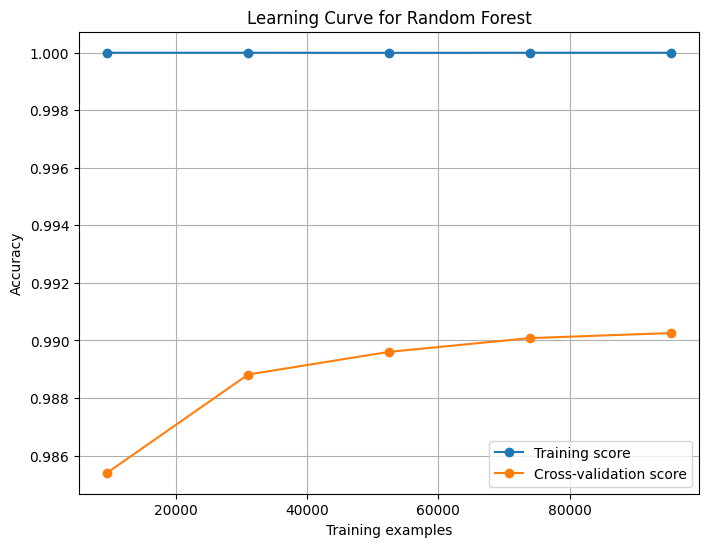

In [ ]:
plot_learning_curve(rf_model, X, y, title='Learning Curve for Random Forest')

* Moderate overfitting but overall a good fit

# Interpretability


--- Tree 1 ---
Node   | Feature            | Gini Reduction
---------------------------------------------
0      | last_pymnt_d       | 0.0769
1      | funded_amnt_inv    | 0.0151
2      | all_util           | 0.0064
3      | total_rec_prncp    | 0.1815
4      | loan_amnt          | 0.0657
5      | last_fico_range_high | 0.3250
6      | recoveries         | 0.0037
7      | total_rec_prncp    | 0.0690
8      | mo_sin_old_rev_tl_op | 0.0109
9      | total_rec_int      | -0.0059
10     | mo_sin_old_rev_tl_op | 0.0607
11     | funded_amnt_inv    | 0.2037
12     | mo_sin_old_rev_tl_op | 0.4444
16     | all_util           | 0.0143
18     | total_rec_prncp    | 0.5000
21     | dti                | 0.0021
22     | last_fico_range_high | 0.5000
26     | last_pymnt_amnt    | 0.5000
31     | out_prncp          | 0.0167
32     | last_fico_range_high | 0.0276
33     | recoveries         | 0.2580
34     | total_pymnt        | 0.1510
36     | total_rec_prncp    | 0.0024
37     | total_rec_prncp    |

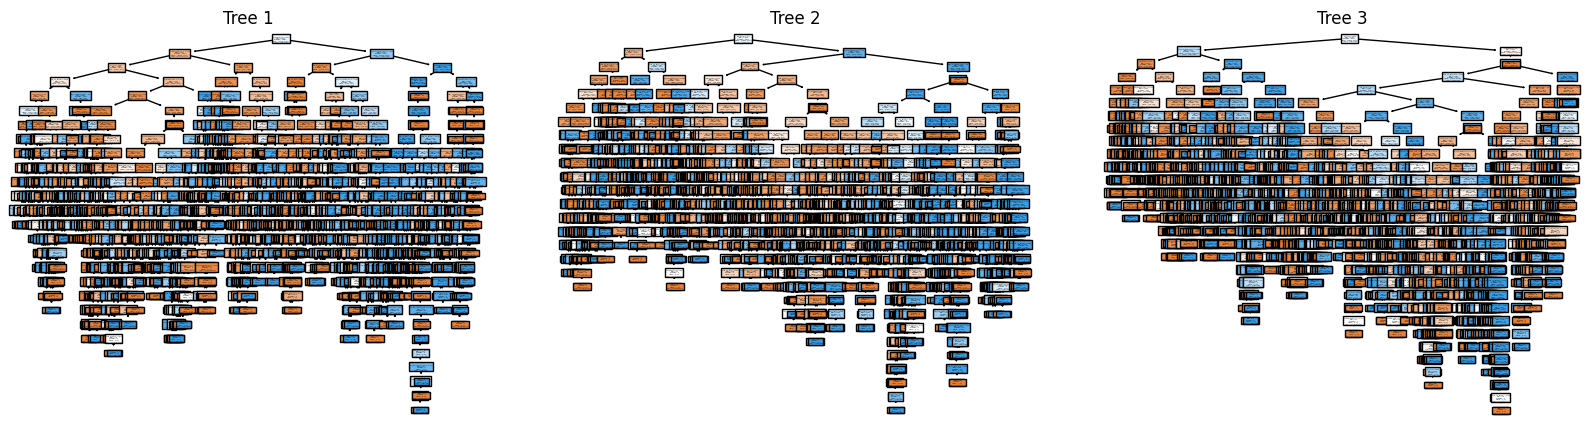

In [ ]:
def calculate_gini(p):
    return 1 - sum(p_i ** 2 for p_i in p)

def get_node_gini_reduction(tree, feature_names):
    """Calculate and print Gini reduction at each split in the tree."""
    tree_ = tree.tree_
    feature = tree_.feature
    impurity = tree_.impurity
    n_node_samples = tree_.n_node_samples

    print("Node   | Feature            | Gini Reduction")
    print("---------------------------------------------")

    for node in range(tree_.node_count):
        if feature[node] != _tree.TREE_UNDEFINED:
            left_child = tree_.children_left[node]
            right_child = tree_.children_right[node]

            # Weighted impurity of children
            n_total = n_node_samples[node]
            weighted_impurity = (
                (n_node_samples[left_child] / n_total) * impurity[left_child]
                + (n_node_samples[right_child] / n_total) * impurity[right_child]
            )
            gini_reduction = impurity[node] - weighted_impurity
            print(f"{node:<6} | {feature_names[feature[node]]:<18} | {gini_reduction:.4f}")

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

for i, ax in enumerate(axes):
    print(f"\n--- Tree {i+1} ---")
    get_node_gini_reduction(rf_model.estimators_[i], X.columns)

    plot_tree(rf_model.estimators_[i], feature_names=X.columns, class_names=["Not Terminated", "Terminated"], filled=True, ax=ax)
    ax.set_title(f"Tree {i+1}")

plt.show()

=== Random Forest Interpretation ===
Number of Trees: 100

*** Global Feature Importance (Gini-based) ***
last_fico_range_high: 0.3669
last_pymnt_d: 0.1289
recoveries: 0.0945
out_prncp: 0.0893
last_pymnt_amnt: 0.0825
out_prncp_inv: 0.0676
total_rec_prncp: 0.0493
total_pymnt: 0.0224
funded_amnt_inv: 0.0151
total_rec_late_fee: 0.0151
loan_amnt: 0.0143
installment: 0.0121
total_rec_int: 0.0101
debt_settlement_flag: 0.0095
revol_util: 0.0040
dti: 0.0039
mo_sin_old_rev_tl_op: 0.0038
all_util: 0.0037
annual_inc: 0.0037
hardship_flag: 0.0031

*** Key Splits in Trees (Highest Gini Reduction) ***

--- Tree 1 ---
Best Split: Node 18 on 'total_rec_prncp'
Gini Reduction: 0.5000
Samples: 2


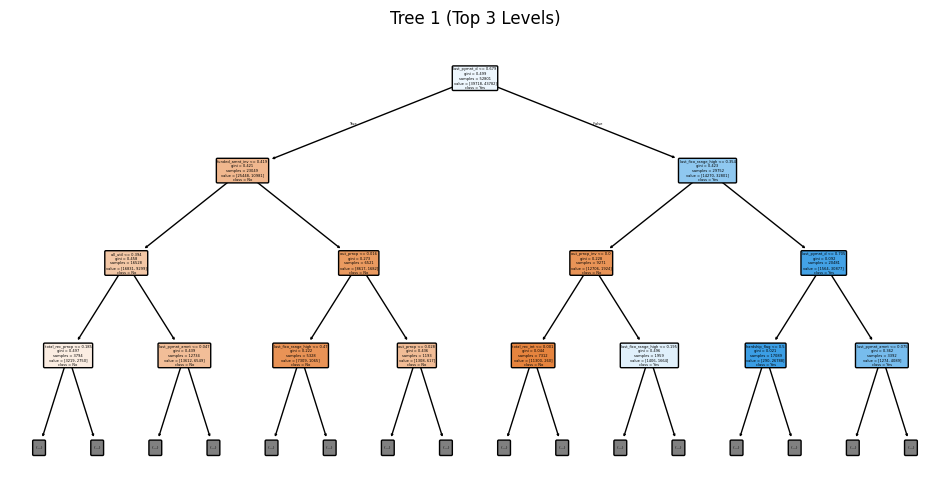


--- Tree 2 ---
Best Split: Node 50 on 'total_rec_prncp'
Gini Reduction: 0.5000
Samples: 7


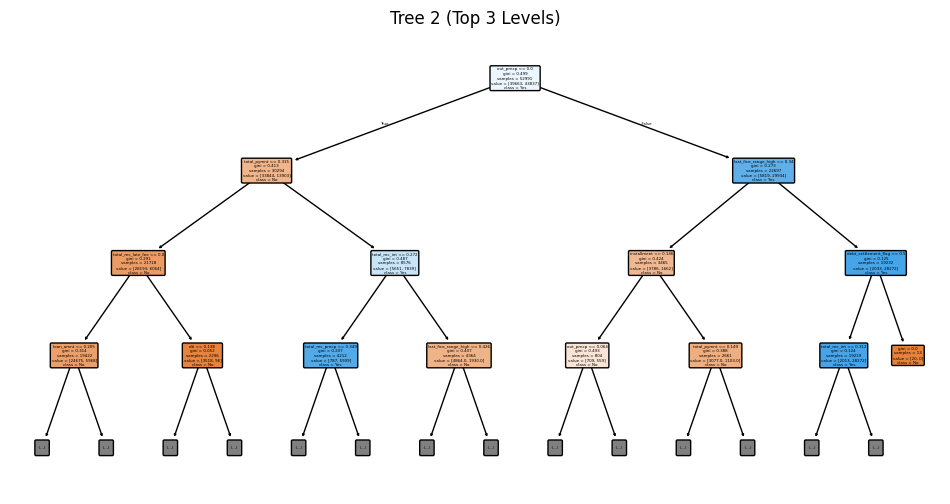


--- Tree 3 ---
Best Split: Node 17 on 'mo_sin_old_rev_tl_op'
Gini Reduction: 0.5000
Samples: 2


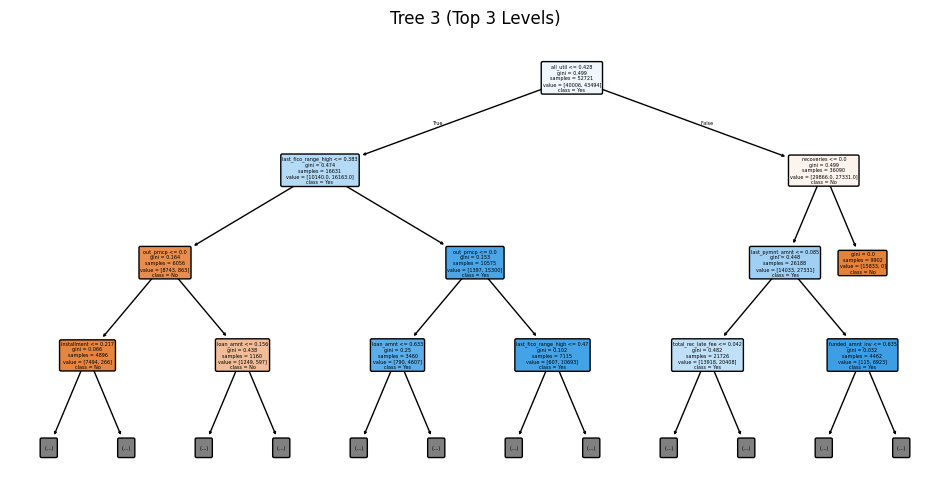

In [ ]:
def interpret_random_forest(rf_model, feature_names, class_names=None, max_trees_to_show=3):
    """
    Simplified Random Forest interpreter.

    Args:
        rf_model: Trained RandomForestClassifier or RandomForestRegressor.
        feature_names: List of feature names (e.g., X.columns).
        class_names: List of class names (for classification). Default=None.
        max_trees_to_show: Max number of trees to visualize. Default=3.
    """
    print("=== Random Forest Interpretation ===")
    print(f"Number of Trees: {len(rf_model.estimators_)}")

    # --- Feature Importance ---
    print("\n*** Global Feature Importance (Gini-based) ***")
    for feature, importance in sorted(
        zip(feature_names, rf_model.feature_importances_),
        key=lambda x: -x[1]
    ):
        print(f"{feature}: {importance:.4f}")

    # --- Analyze Individual Trees ---
    print("\n*** Key Splits in Trees (Highest Gini Reduction) ***")
    for i, tree in enumerate(rf_model.estimators_[:max_trees_to_show]):
        print(f"\n--- Tree {i+1} ---")
        tree_ = tree.tree_

        # Find the split with max Gini reduction
        best_node = None
        best_reduction = -1
        best_feature = None

        for node in range(tree_.node_count):
            if tree_.feature[node] != -2:  # Not a leaf node
                left = tree_.children_left[node]
                right = tree_.children_right[node]

                n_total = tree_.n_node_samples[node]
                weighted_impurity = (
                    (tree_.n_node_samples[left] / n_total) * tree_.impurity[left] +
                    (tree_.n_node_samples[right] / n_total) * tree_.impurity[right]
                )
                gini_reduction = tree_.impurity[node] - weighted_impurity

                if gini_reduction > best_reduction:
                    best_reduction = gini_reduction
                    best_node = node
                    best_feature = feature_names[tree_.feature[node]]

        print(
            f"Best Split: Node {best_node} on '{best_feature}'\n"
            f"Gini Reduction: {best_reduction:.4f}\n"
            f"Samples: {tree_.n_node_samples[best_node]}"
        )

        plt.figure(figsize=(12, 6))
        plot_tree(
            tree,
            feature_names=feature_names,
            class_names=class_names,
            filled=True,
            rounded=True,
            max_depth=3  # Limit depth for readability
        )
        plt.title(f"Tree {i+1} (Top 3 Levels)")
        plt.show()

interpret_random_forest(rf_model, X.columns, class_names=["No", "Yes"])

## SHAP (Global & Local Explanations)

Type of shap_values: <class 'numpy.ndarray'>


<Figure size 640x480 with 0 Axes>

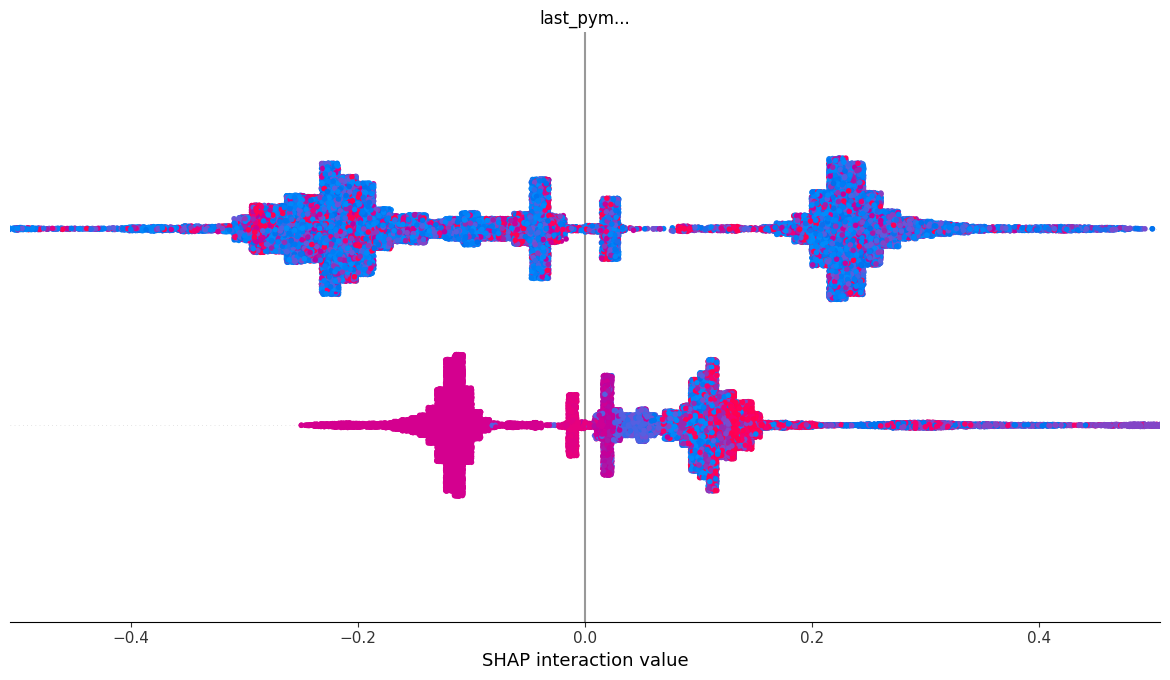

In [ ]:
# TreeExplainer is efficient for Random Forest
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Check the type
print(f"Type of shap_values: {type(shap_values)}")

if isinstance(shap_values, list):
    # Binary classification: shap_values[1]
    shap.summary_plot(shap_values[1], X_test, feature_names=X_test.columns)
else:
    # Regression or already flattened
    shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

The feature last_pymnt_d shows moderate influence through its interaction with another feature. This is indicated by distinct horizontal bands and a noticeable spread of SHAP interaction values across both positive and negative ranges. Interactions are stronger when last_pymnt_d combines with high values of the second feature (red points), pushing predictions higher. For most instances, interaction effects are small, as shown by clustering around zero, suggesting limited overall impact.

## LIME

In [ ]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['Not Terminated', 'Terminated'],
    mode='classification'
)

i = 0
exp = lime_explainer.explain_instance(
    X_test.iloc[i],
    rf_model.predict_proba,
    num_features=10
)

exp.show_in_notebook(show_table=True)

/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

* The model predicted "Terminated" with 100% confidence.

---

These features pushed the prediction toward "Terminated":

* recoveries = 0.00 → strong impact (0.21)
No recovered funds strongly support termination.

* last_pymnt_amnt = 0.10 → moderate impact (0.17)
A small last payment amount supports termination.

* debt_settlement_flag = 0.00 → some impact (0.14)
No debt settlement still leans toward termination.

* last_pymnt_d = 0.97 → recent last payment increases termination likelihood (0.11).

These features slightly pushed against termination:

* funded_amnt_inv = 0.06, total_rec_prncp = 0.12, loan_amnt = 0.05
Their values suggest slight repayment activity or small loan, offering minor evidence against termination.


##  PDP

Skipping 'debt_settlement_flag': cannot reshape array of size 1 into shape (2)
Skipping 'hardship_flag': cannot reshape array of size 1 into shape (2)


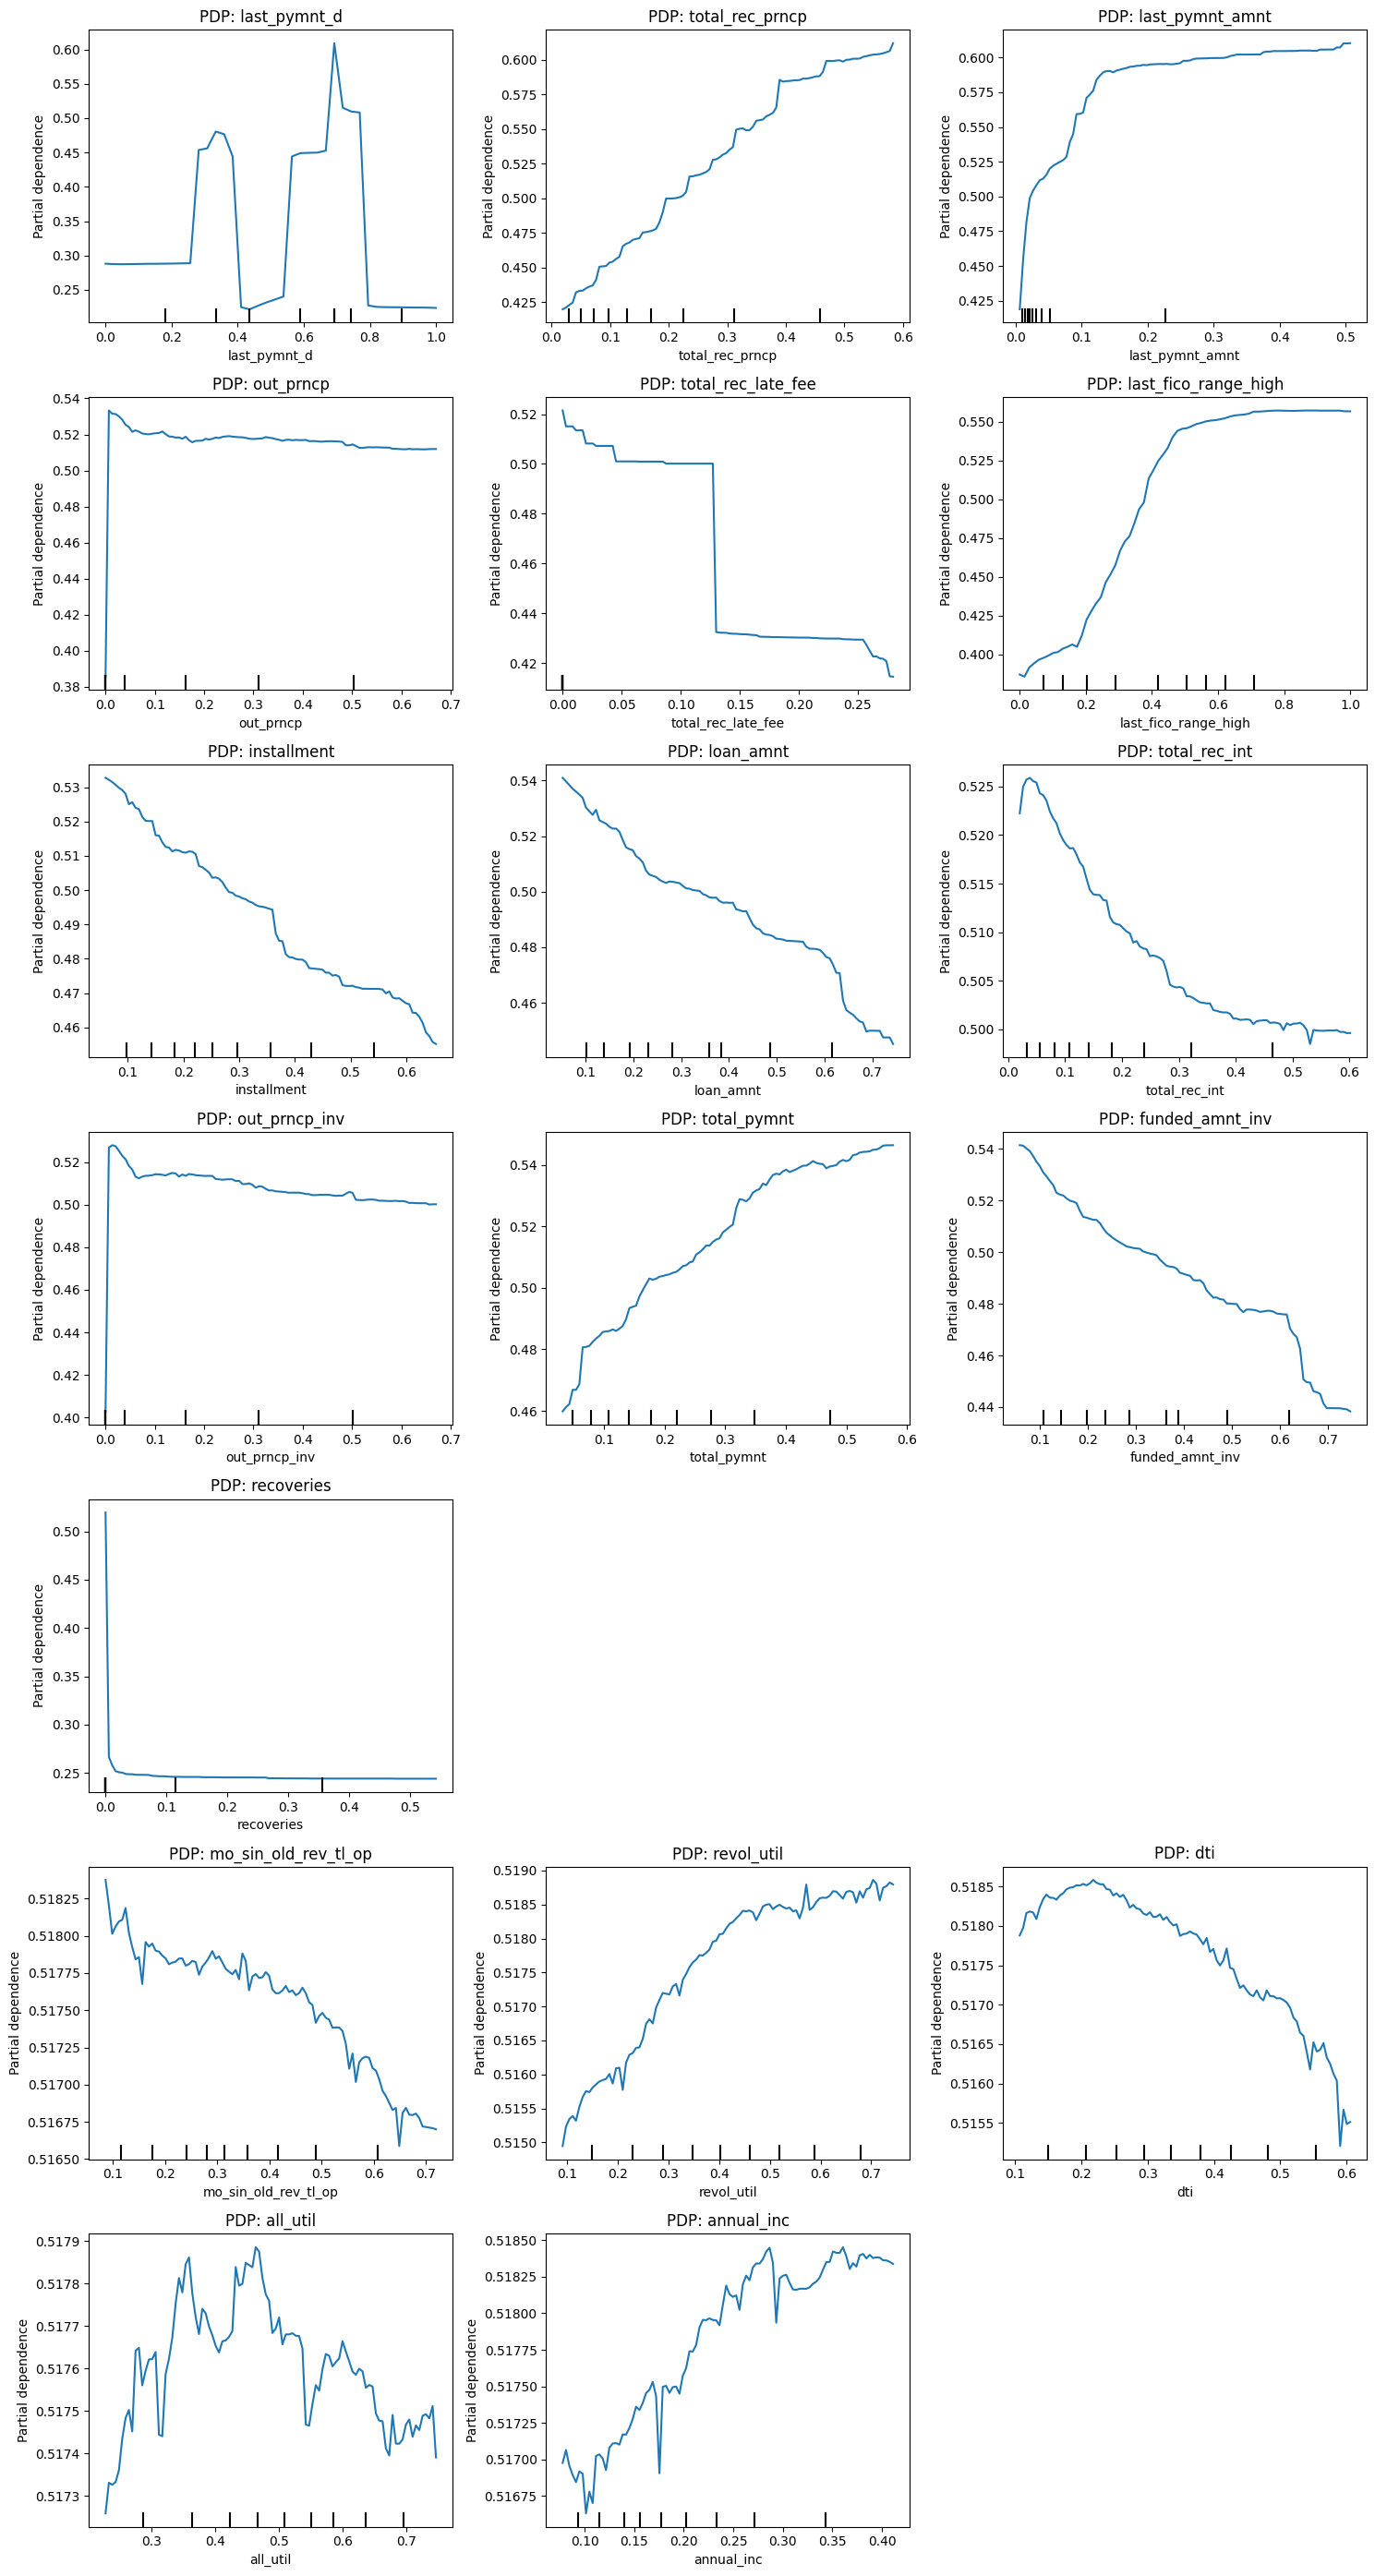

In [ ]:
numeric_features = [col for col in X_test.columns if pd.api.types.is_numeric_dtype(X_test[col])]

n_cols = 3
n_rows = (len(numeric_features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    try:
        PartialDependenceDisplay.from_estimator(
            rf_model,
            X_test,
            [feature],
            ax=axes[i]
        )
        axes[i].set_title(f"PDP: {feature}")
    except Exception as e:
        print(f"Skipping '{feature}': {e}")
        fig.delaxes(axes[i])

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


* Upward slope -> Higher values of the feature increase the prediction.
* Downward slope -> Higher values of the feature decrease the prediction.
* Flat line -> Feature has little or no impact on the prediction.
* Nonlinear shapes -> Show interactions or thresholds in how the feature affects outcome.


## PFI

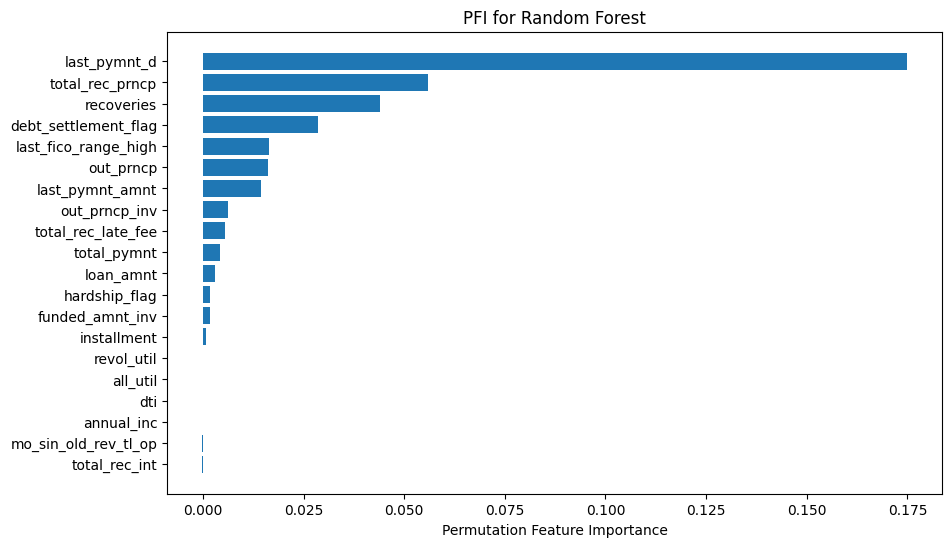

In [ ]:
pfi_result = permutation_importance(
    rf_model,
    X_test,
    y_test,
    n_repeats=30,
    random_state=42,
    n_jobs=-1
)

sorted_idx = pfi_result.importances_mean.argsort()
plt.figure(figsize=(10, 6))
plt.barh(X_test.columns[sorted_idx], pfi_result.importances_mean[sorted_idx])
plt.xlabel("Permutation Feature Importance")
plt.title("PFI for Random Forest")
plt.show()

the lst payment date feature has high infeluence on the model. since it has the higher PFI

